# Train/Test/Val Split 

This notebook implements data splitting strategy:

### Constraints:
1. **Coverage Constraints**:
   - Every item in val/test must appear in train at least once
   - Every user in val/test must appear in train

2. **Popularity Balance**:
   - Keep item-popularity distribution similar across splits
   - Preserve the fraction of items in popularity bins (1-5, 6-10, 11-50, etc.)

3. **Per-User Ratios**:
   - Roughly 80/10/10 per user
   - Skip users with <3 interactions (can't split meaningfully)

### Strategy:
1. Start with all interactions in train
2. For each eligible user, move 1 item to test and 1 to val
3. Only move items if train count remains >= 1
4. Prefer items whose popularity bin is under-represented in val/test

## 1. Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import random
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Load Processed Data

In [14]:
def load_data(filepath):
    """Load user-item interaction data"""
    user_items = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            items = line.split()
            if len(items) < 2:
                continue
            user_id = int(items[0])
            item_list = [int(x) for x in items[1:]]
            user_items.append((user_id, item_list))
    return user_items

print("Loading train-2-interim.txt:")
user_items = load_data('train-2-interim.txt')
print(f" Loaded {len(user_items):,} users")

# Calculate global statistics
all_items = []
for _, items in user_items:
    all_items.extend(items)

print(f" Total interactions: {len(all_items):,}")
print(f" Unique items: {len(set(all_items)):,}")

Loading train-2-interim.txt:
 Loaded 51,420 users
 Total interactions: 1,961,174
 Unique items: 91,522


## Calculate Global Item Popularity & Define Bins

In [17]:
print("CALCULATING GLOBAL ITEM POPULARITY")
print("="*70)

# Count item frequencies globally
global_item_freq = Counter(all_items)

print(f"\nTotal unique items: {len(global_item_freq):,}")
print(f"Item frequency range: {min(global_item_freq.values())} to {max(global_item_freq.values()):,}")

# Define popularity bins
popularity_bins = [
    (1, 5, 'very-rare'),
    (6, 10, 'rare'),
    (11, 50, 'common'),
    (51, 100, 'popular'),
    (101, 500, 'very-popular'),
    (501, float('inf'), 'extremely-popular')
]

def get_popularity_bin(freq):
    """Get the popularity bin for an item frequency"""
    for min_val, max_val, label in popularity_bins:
        if min_val <= freq <= max_val:
            return label
    return 'unknown'

# Assign each item to a popularity bin
item_to_bin = {item: get_popularity_bin(freq) for item, freq in global_item_freq.items()}

# Count items per bin
bin_counts = Counter(item_to_bin.values())

print("\nGlobal Item Popularity Distribution:")
for min_val, max_val, label in popularity_bins:
    count = bin_counts[label]
    percentage = (count / len(global_item_freq)) * 100
    range_str = f"{min_val}-{max_val}" if max_val != float('inf') else f"{min_val}+"
    print(f"  {label:20s} ({range_str:10s}): {count:6,} items ({percentage:5.2f}%)")


CALCULATING GLOBAL ITEM POPULARITY

Total unique items: 91,522
Item frequency range: 1 to 1,556

Global Item Popularity Distribution:
  very-rare            (1-5       ):  8,916 items ( 9.74%)
  rare                 (6-10      ): 28,896 items (31.57%)
  common               (11-50     ): 46,736 items (51.07%)
  popular              (51-100    ):  4,977 items ( 5.44%)
  very-popular         (101-500   ):  1,940 items ( 2.12%)
  extremely-popular    (501+      ):     57 items ( 0.06%)


## 4. Initialize Splits

In [20]:
print("INITIALIZING SPLITS")
print("="*70)

# Initialize: all interactions start in train
train_data = {uid: items.copy() for uid, items in user_items}
val_data = {uid: [] for uid, _ in user_items}
test_data = {uid: [] for uid, _ in user_items}

# Track item counts in train (critical for coverage constraint)
train_item_counts = Counter()
for items in train_data.values():
    train_item_counts.update(items)

print(f"\n Initialized splits:")
print(f" Train: {sum(len(items) for items in train_data.values()):,} interactions")
print(f" Val: {sum(len(items) for items in val_data.values()):,} interactions")
print(f" Test: {sum(len(items) for items in test_data.values()):,} interactions")
print(f"\n Train item counts calculated: {len(train_item_counts):,} unique items")

INITIALIZING SPLITS

 Initialized splits:
 Train: 1,961,174 interactions
 Val: 0 interactions
 Test: 0 interactions

 Train item counts calculated: 91,522 unique items


## Implementing Splitting Algorithm

In [23]:
print("PERFORMING SMART SPLIT")
print("="*70)

# Track popularity distribution in val/test for balancing
val_bin_counts = Counter()
test_bin_counts = Counter()

MIN_INTERACTIONS_FOR_SPLIT = 3  # Need at least 3 to do 80/10/10
skipped_users = 0
processed_users = 0

print(f"\nProcessing users (minimum {MIN_INTERACTIONS_FOR_SPLIT} interactions )\n")

for uid, original_items in user_items:
    n_items = len(original_items)
    
    # Skip users with too few interactions
    if n_items < MIN_INTERACTIONS_FOR_SPLIT:
        skipped_users += 1
        continue
    
    processed_users += 1
    
    # Shuffle user's items for randomness
    shuffled_items = original_items.copy()
    random.shuffle(shuffled_items)
    
    # Try to move 1 item to val and 1 to test
    moved_to_val = False
    moved_to_test = False
    
    for item in shuffled_items:
        # Get item's popularity bin
        item_bin = item_to_bin[item]

        if not moved_to_val:
            # Check coverage constraint: item must remain in train at least once
            if train_item_counts[item] > 1:
                # Check if this bin is under-represented in val
                global_bin_ratio = bin_counts[item_bin] / len(global_item_freq)
                current_val_total = sum(val_bin_counts.values())
                current_val_ratio = val_bin_counts[item_bin] / max(current_val_total, 1)
                
                # Move if bin is under-represented or randomly with lower probability
                if current_val_ratio < global_bin_ratio or random.random() < 0.3:
                    train_data[uid].remove(item)
                    val_data[uid].append(item)
                    train_item_counts[item] -= 1
                    val_bin_counts[item_bin] += 1
                    moved_to_val = True
                    continue
        
        if not moved_to_test:
            # Check coverage constraint
            if train_item_counts[item] > 1:
                # Check if this bin is under-represented in test
                global_bin_ratio = bin_counts[item_bin] / len(global_item_freq)
                current_test_total = sum(test_bin_counts.values())
                current_test_ratio = test_bin_counts[item_bin] / max(current_test_total, 1)
                
                # Move if bin is under-represented or randomly with lower probability
                if current_test_ratio < global_bin_ratio or random.random() < 0.3:
                    train_data[uid].remove(item)
                    test_data[uid].append(item)
                    train_item_counts[item] -= 1
                    test_bin_counts[item_bin] += 1
                    moved_to_test = True
                    continue
        
        # Both moves done, stop processing this user
        if moved_to_val and moved_to_test:
            break

    if processed_users % 10000 == 0:
        print(f"  Processed {processed_users:,} users...")

print(f"\n Split complete")
print(f" Processed users: {processed_users:,}")
print(f" Skipped users (<{MIN_INTERACTIONS_FOR_SPLIT} interactions): {skipped_users:,}")

PERFORMING SMART SPLIT

Processing users (minimum 3 interactions )

  Processed 10,000 users...
  Processed 20,000 users...
  Processed 30,000 users...
  Processed 40,000 users...
  Processed 50,000 users...

 Split complete
 Processed users: 51,420
 Skipped users (<3 interactions): 0


## Verify Split

In [25]:
print("SPLIT STATISTICS")
print("="*70)

# Calculate sizes
train_interactions = sum(len(items) for items in train_data.values())
val_interactions = sum(len(items) for items in val_data.values())
test_interactions = sum(len(items) for items in test_data.values())
total_interactions = train_interactions + val_interactions + test_interactions

train_pct = (train_interactions / total_interactions) * 100
val_pct = (val_interactions / total_interactions) * 100
test_pct = (test_interactions / total_interactions) * 100

print(f"\nInteraction Counts:")
print(f"  Train: {train_interactions:,} ({train_pct:.2f}%)")
print(f"  Val:   {val_interactions:,} ({val_pct:.2f}%)")
print(f"  Test:  {test_interactions:,} ({test_pct:.2f}%)")
print(f"  Total: {total_interactions:,}")

# User coverage
train_users = sum(1 for items in train_data.values() if len(items) > 0)
val_users = sum(1 for items in val_data.values() if len(items) > 0)
test_users = sum(1 for items in test_data.values() if len(items) > 0)

print(f"\n User Coverage:")
print(f" Train: {train_users:,} users")
print(f" Val:   {val_users:,} users")
print(f" Test:  {test_users:,} users")

# Item coverage
train_unique_items = set(item for items in train_data.values() for item in items)
val_unique_items = set(item for items in val_data.values() for item in items)
test_unique_items = set(item for items in test_data.values() for item in items)

print(f"\n Unique Items:")
print(f" Train: {len(train_unique_items):,} items")
print(f" Val:   {len(val_unique_items):,} items")
print(f" Test:  {len(test_unique_items):,} items")

SPLIT STATISTICS

Interaction Counts:
  Train: 1,858,345 (94.76%)
  Val:   51,418 (2.62%)
  Test:  51,411 (2.62%)
  Total: 1,961,174

 User Coverage:
 Train: 51,420 users
 Val:   51,418 users
 Test:  51,411 users

 Unique Items:
 Train: 91,522 items
 Val:   34,907 items
 Test:  33,569 items


## Verify Popularity Balance

In [29]:
print("VERIFYING POPULARITY BALANCE")
print("="*70)

# Calculate item frequency in each split
def get_item_frequencies(data_dict):
    freq = Counter()
    for items in data_dict.values():
        freq.update(items)
    return freq

train_freq = get_item_frequencies(train_data)
val_freq = get_item_frequencies(val_data)
test_freq = get_item_frequencies(test_data)

# Assign items to bins in each split
def get_bin_distribution(item_freq):
    bin_dist = Counter()
    for item, freq in item_freq.items():
        bin_label = get_popularity_bin(freq)
        bin_dist[bin_label] += 1
    return bin_dist

train_bin_dist = get_bin_distribution(train_freq)
val_bin_dist = get_bin_distribution(val_freq)
test_bin_dist = get_bin_distribution(test_freq)

# Create comparison table
print("\n Popularity Distribution (% of unique items in each bin):\n")
print(f"{'Bin':<25} {'Global':<12} {'Train':<12} {'Val':<12} {'Test':<12}")
print("-" * 73)

for min_val, max_val, label in popularity_bins:
    global_pct = (bin_counts[label] / len(global_item_freq)) * 100
    train_pct = (train_bin_dist[label] / max(len(train_unique_items), 1)) * 100
    val_pct = (val_bin_dist[label] / max(len(val_unique_items), 1)) * 100
    test_pct = (test_bin_dist[label] / max(len(test_unique_items), 1)) * 100
    
    print(f"{label:<25} {global_pct:>6.2f}%     {train_pct:>6.2f}%     {val_pct:>6.2f}%     {test_pct:>6.2f}%")

VERIFYING POPULARITY BALANCE

 Popularity Distribution (% of unique items in each bin):

Bin                       Global       Train        Val          Test        
-------------------------------------------------------------------------
very-rare                   9.74%      12.84%      98.95%      98.55%
rare                       31.57%      31.38%       0.87%       1.17%
common                     51.07%      48.58%       0.17%       0.28%
popular                     5.44%       5.16%       0.00%       0.00%
very-popular                2.12%       1.98%       0.00%       0.00%
extremely-popular           0.06%       0.05%       0.00%       0.00%


## Verify Per-User Split Ratios

In [32]:
print("VERIFYING PER-USER SPLIT RATIOS")
print("="*70)

# Calculate per-user split ratios
user_split_ratios = []

for uid, _ in user_items:
    n_train = len(train_data[uid])
    n_val = len(val_data[uid])
    n_test = len(test_data[uid])
    n_total = n_train + n_val + n_test
    
    if n_total >= MIN_INTERACTIONS_FOR_SPLIT:
        train_ratio = (n_train / n_total) * 100
        val_ratio = (n_val / n_total) * 100
        test_ratio = (n_test / n_total) * 100
        user_split_ratios.append((train_ratio, val_ratio, test_ratio))

# Calculate statistics
train_ratios = [r[0] for r in user_split_ratios]
val_ratios = [r[1] for r in user_split_ratios]
test_ratios = [r[2] for r in user_split_ratios]

print(f"\n Per-User Split Ratios (for {len(user_split_ratios):,} users with ≥{MIN_INTERACTIONS_FOR_SPLIT} interactions):\n")
print(f"{'Split':<10} {'Mean':<10} {'Median':<10} {'Std Dev':<10} {'Min':<10} {'Max':<10}")
print("-" * 60)
print(f"{'Train':<10} {np.mean(train_ratios):>6.2f}%   {np.median(train_ratios):>6.2f}%   {np.std(train_ratios):>6.2f}%   {np.min(train_ratios):>6.2f}%   {np.max(train_ratios):>6.2f}%")
print(f"{'Val':<10} {np.mean(val_ratios):>6.2f}%   {np.median(val_ratios):>6.2f}%   {np.std(val_ratios):>6.2f}%   {np.min(val_ratios):>6.2f}%   {np.max(val_ratios):>6.2f}%")
print(f"{'Test':<10} {np.mean(test_ratios):>6.2f}%   {np.median(test_ratios):>6.2f}%   {np.std(test_ratios):>6.2f}%   {np.min(test_ratios):>6.2f}%   {np.max(test_ratios):>6.2f}%")

VERIFYING PER-USER SPLIT RATIOS

 Per-User Split Ratios (for 51,420 users with ≥3 interactions):

Split      Mean       Median     Std Dev    Min        Max       
------------------------------------------------------------
Train       92.48%    92.31%     3.44%    87.50%    99.00%
Val          3.76%     3.85%     1.72%     0.00%     6.25%
Test         3.76%     3.85%     1.72%     0.00%     6.25%


## Visualizations

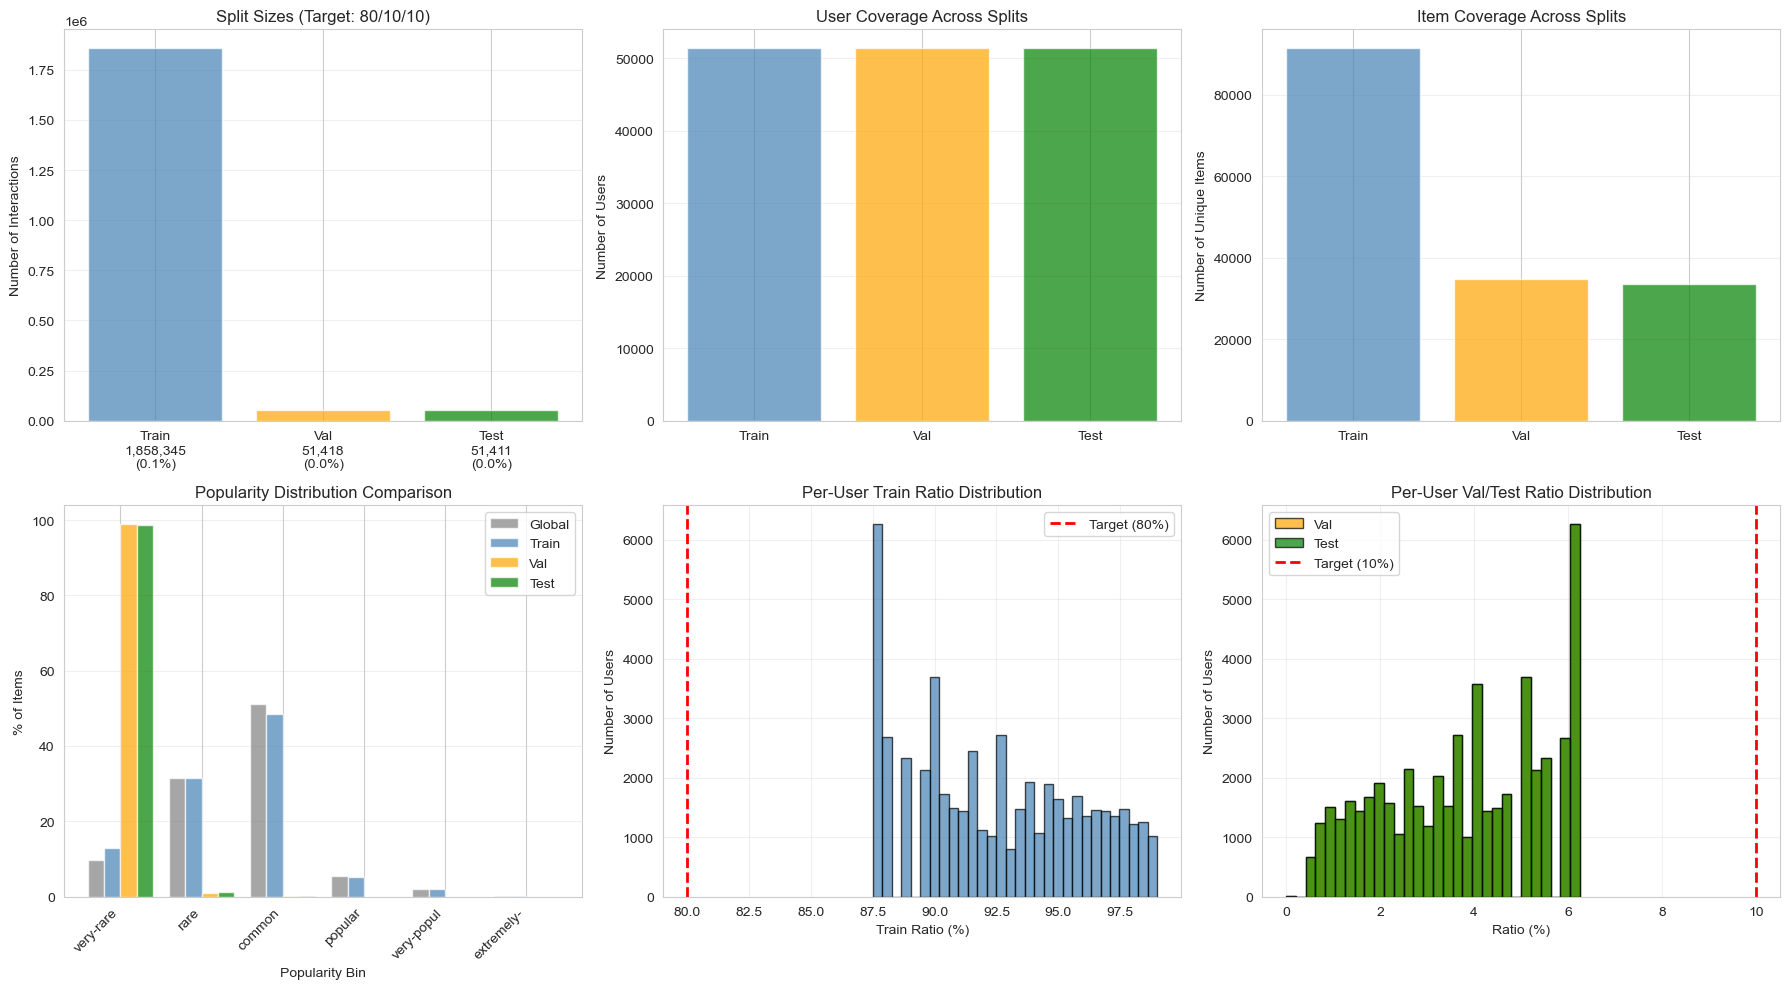

In [35]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot: Split size comparison
split_sizes = [train_interactions, val_interactions, test_interactions]
split_labels = [f'Train\n{train_interactions:,}\n({train_pct:.1f}%)', 
                f'Val\n{val_interactions:,}\n({val_pct:.1f}%)', 
                f'Test\n{test_interactions:,}\n({test_pct:.1f}%)']
colors = ['steelblue', 'orange', 'green']
axes[0, 0].bar(range(3), split_sizes, color=colors, alpha=0.7)
axes[0, 0].set_xticks(range(3))
axes[0, 0].set_xticklabels(split_labels)
axes[0, 0].set_ylabel('Number of Interactions')
axes[0, 0].set_title('Split Sizes (Target: 80/10/10)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot: User coverage
user_counts = [train_users, val_users, test_users]
axes[0, 1].bar(range(3), user_counts, color=colors, alpha=0.7)
axes[0, 1].set_xticks(range(3))
axes[0, 1].set_xticklabels(['Train', 'Val', 'Test'])
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('User Coverage Across Splits')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot: Item coverage
item_counts = [len(train_unique_items), len(val_unique_items), len(test_unique_items)]
axes[0, 2].bar(range(3), item_counts, color=colors, alpha=0.7)
axes[0, 2].set_xticks(range(3))
axes[0, 2].set_xticklabels(['Train', 'Val', 'Test'])
axes[0, 2].set_ylabel('Number of Unique Items')
axes[0, 2].set_title('Item Coverage Across Splits')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Plot: Popularity distribution comparison
bin_labels_short = [label for _, _, label in popularity_bins]
x = np.arange(len(bin_labels_short))
width = 0.2

global_pcts = [(bin_counts[label] / len(global_item_freq)) * 100 for label in bin_labels_short]
train_pcts = [(train_bin_dist[label] / max(len(train_unique_items), 1)) * 100 for label in bin_labels_short]
val_pcts = [(val_bin_dist[label] / max(len(val_unique_items), 1)) * 100 for label in bin_labels_short]
test_pcts = [(test_bin_dist[label] / max(len(test_unique_items), 1)) * 100 for label in bin_labels_short]

axes[1, 0].bar(x - 1.5*width, global_pcts, width, label='Global', color='gray', alpha=0.7)
axes[1, 0].bar(x - 0.5*width, train_pcts, width, label='Train', color='steelblue', alpha=0.7)
axes[1, 0].bar(x + 0.5*width, val_pcts, width, label='Val', color='orange', alpha=0.7)
axes[1, 0].bar(x + 1.5*width, test_pcts, width, label='Test', color='green', alpha=0.7)
axes[1, 0].set_xlabel('Popularity Bin')
axes[1, 0].set_ylabel('% of Items')
axes[1, 0].set_title('Popularity Distribution Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([l[:10] for l in bin_labels_short], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot: Per-user train ratio distribution
axes[1, 1].hist(train_ratios, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].axvline(80, color='red', linestyle='--', linewidth=2, label='Target (80%)')
axes[1, 1].set_xlabel('Train Ratio (%)')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].set_title('Per-User Train Ratio Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot: Per-user val/test ratio distribution
axes[1, 2].hist(val_ratios, bins=30, edgecolor='black', alpha=0.7, color='orange', label='Val')
axes[1, 2].hist(test_ratios, bins=30, edgecolor='black', alpha=0.7, color='green', label='Test')
axes[1, 2].axvline(10, color='red', linestyle='--', linewidth=2, label='Target (10%)')
axes[1, 2].set_xlabel('Ratio (%)')
axes[1, 2].set_ylabel('Number of Users')
axes[1, 2].set_title('Per-User Val/Test Ratio Distribution')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Split Data to Files

In [37]:
print("SAVING SPLIT DATA")
print("="*70)

def save_split(data_dict, base_filename):
    """Save split data to file"""
    txt_path = f"{base_filename}.txt"
    with open(txt_path, 'w') as f:
        for uid in sorted(data_dict.keys()):
            items = data_dict[uid]
            if len(items) > 0:  # Only save users with interactions
                f.write(f"{uid} " + " ".join(map(str, items)) + "\n")
    print(f"{txt_path} - Saved")

    # --- Convert to DataFrame ---
    rows = []
    for uid, items in data_dict.items():
        for item in items:
            rows.append((uid, item))
    df = pd.DataFrame(rows, columns=["user_id", "item_id"])

    # --- Save as CSV ---
    csv_path = f"{base_filename}.csv"
    df.to_csv(csv_path, index=False)
    print(f"{csv_path} - Saved ({len(df):,} rows)")

    # --- Save as Parquet ---
    parquet_path = f"{base_filename}.parquet"
    df.to_parquet(parquet_path, index=False)
    print(f"{parquet_path} - Saved ({len(df):,} rows)")
    
# Save each split
print("\nSaving splits\n")
save_split(train_data, 'train_split')

save_split(val_data, 'val_split')

save_split(test_data, 'test_split')

SAVING SPLIT DATA

Saving splits

train_split.txt - Saved
train_split.csv - Saved (1,858,345 rows)
train_split.parquet - Saved (1,858,345 rows)
val_split.txt - Saved
val_split.csv - Saved (51,418 rows)
val_split.parquet - Saved (51,418 rows)
test_split.txt - Saved
test_split.csv - Saved (51,411 rows)
test_split.parquet - Saved (51,411 rows)
